<h4>Imports</h4>

In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mplsoccer as mpls
from mplsoccer import Pitch, VerticalPitch, FontManager
import matplotlib.ticker as ticker
from matplotlib import cm
from matplotlib.colors import ListedColormap

import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter

In [58]:
df = pd.read_csv('datasets/euro2020data_combined.csv')

C:\Users\Aykut\AppData\Local\Temp\ipykernel_4272\505737534.py:1: DtypeWarning: Columns (17,69,74,75,81,85,89,90,91,100,102,103,104,105,106,107,108,110,111,112,113,114,115,118,119,120,121,122,123,124,125,126,127,128,129,131,132,133,134,135,136,137,138,139,140,141,142,143) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('datasets/euro2020data_combined.csv')


<h2>Data Handling

In [59]:
df.head()

,id,index,period,timestamp,minute,second,possession,duration,type_id,type_name,...,next_event,previous_event,next_team_possession,previous_team_possession,possession_retained,endloc_x,endloc_y,dist1,dist2,diffdist
0,2e4b1b7f-e67e-4bef-8cf1-2eab2ab81af2,1,1,00:00:00.000,0,0,1,0.000000,35,Starting XI,...,Starting XI,NaN,Switzerland,NaN,1,NaN,NaN,NaN,NaN,NaN
1,f73c3f38-8c45-4802-8cb9-5a87234f385b,2,1,00:00:00.000,0,0,1,0.000000,35,Starting XI,...,Half Start,Starting XI,Switzerland,Switzerland,1,NaN,NaN,NaN,NaN,NaN
2,9098375d-3f07-4241-bdc9-3602a2e5c754,3,1,00:00:00.000,0,0,1,0.000000,18,Half Start,...,Half Start,Starting XI,Switzerland,Switzerland,1,NaN,NaN,NaN,NaN,NaN
3,18099197-a92a-4398-ac5e-39dad539c3eb,4,1,00:00:00.000,0,0,1,0.000000,18,Half Start,...,Pass,Half Start,Spain,Switzerland,0,NaN,NaN,NaN,NaN,NaN
4,ea57ee78-a4ef-4d62-81c7-98cdf1c11925,5,1,00:00:00.967,0,0,2,1.511008,30,Pass,...,Ball Receipt*,Half Start,Spain,Switzerland,1,35.2,33.3,59.000085,85.06427,-26.064185


In [60]:
df.shape

(192692, 174)

In [61]:
with pd.option_context('display.max_rows', 174, 'display.max_columns', None):
    print(df.dtypes)

id                                   object
index                                 int64
period                                int64
timestamp                            object
minute                                int64
second                                int64
possession                            int64
duration                            float64
type_id                               int64
type_name                            object
possession_team_id                    int64
possession_team_name                 object
play_pattern_id                       int64
play_pattern_name                    object
team_id                               int64
team_name                            object
tactics_formation                   float64
tactics_lineup                       object
related_events                       object
location                             object
player_id                           float64
player_name                          object
position_id                     

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192692 entries, 0 to 192691
Columns: 174 entries, id to diffdist
dtypes: float64(53), int64(12), object(109)
memory usage: 255.8+ MB


In [63]:
match_count = df['match_id'].nunique()
event_count = len(df)
shot_count =  len(df[(df['type_name'] == 'Shot')])
goal_count = len(df[(df['shot_outcome_name'] == 'Goal')])
pass_count = len(df[(df['type_name'] == 'Pass')])

print('Number of matches: ', match_count)
print('Number of events: ', event_count)
print('Number of shots: ', shot_count)
print('Number of goals: ', goal_count)
print('Number of passes: ', pass_count)


Number of matches:  51
Number of events:  192692
Number of shots:  1289
Number of goals:  155
Number of passes:  54819


In [64]:
type_counts = df['type_name'].value_counts()

# Display the type counts
print(type_counts)

Pass                 54819
Ball Receipt*        52721
Carry                43801
Pressure             15958
Ball Recovery         4445
Duel                  3355
Clearance             2283
Block                 1770
Goal Keeper           1514
Dribble               1476
Interception          1460
Foul Committed        1394
Foul Won              1337
Shot                  1289
Miscontrol            1273
Dispossessed          1087
Dribbled Past          894
Substitution           454
Injury Stoppage        288
Half Start             244
Half End               244
Tactical Shift         125
Referee Ball-Drop      121
Starting XI            102
Shield                  58
50/50                   56
Bad Behaviour           26
Error                   24
Player Off              22
Player On               21
Own Goal Against        11
Own Goal For            11
Offside                  9
Name: type_name, dtype: int64


<h5> Creating functions and dataframes for later use

In [65]:
turkey_matches = df.loc[df['team_name'] == 'Turkey', ['match_id', 'home_team_name', 'away_team_name']].drop_duplicates().reset_index(drop=True)
matchids = turkey_matches['match_id'].tolist()
matchids

[3788755, 3788741, 3788765]

In [175]:
forxg = df[(df['type_name'] == 'Shot') & (df['match_id'].isin(matchids))]
forxg = forxg[["match_id",'minute', 'team_name', 'shot_statsbomb_xg', 'shot_outcome_name', 'location']]
forxg['location_x'] = forxg['location'].str.split(',', expand=True)[0].str.strip()
forxg['location_y'] = forxg['location'].str.split(',', expand=True)[1].str.strip()
forxg['location_x'] = pd.to_numeric(forxg['location_x'], errors='coerce')
forxg['location_y'] = pd.to_numeric(forxg['location_y'], errors='coerce')
forxg['shot_statsbomb_xg'] = pd.to_numeric(forxg['shot_statsbomb_xg'], errors='coerce')

forxg = forxg.drop('location', axis=1)
forxg.groupby("match_id")
forxg.sort_values(by=['match_id', 'minute'], inplace=True)
forxg.reset_index(drop=True, inplace=True)

forxg

,match_id,minute,team_name,shot_statsbomb_xg,shot_outcome_name,location_x,location_y
0,3788741,2,Italy,0.052236,Off T,114.6,50.1
1,3788741,13,Italy,0.009444,Blocked,98.9,58.7
2,3788741,17,Italy,0.098552,Off T,108.2,27.3
3,3788741,19,Italy,0.006578,Off T,87.0,53.6
4,3788741,20,Italy,0.051247,Blocked,97.1,44.3
...,...,...,...,...,...,...,...
99,3788765,79,Switzerland,0.064403,Blocked,104.4,44.1
100,3788765,82,Turkey,0.034126,Blocked,96.9,51.1
101,3788765,82,Turkey,0.204877,Off T,113.4,41.1
102,3788765,88,Turkey,0.146092,Saved,108.4,37.1


In [68]:
shot_count_by_match = forxg.groupby(['match_id', 'team_name']).size().reset_index(name='shot_count')
shot_count_by_match

,match_id,team_name,shot_count
0,3788741,Italy,24
1,3788741,Turkey,3
2,3788755,Turkey,18
3,3788755,Wales,16
4,3788765,Switzerland,23
5,3788765,Turkey,20


In [69]:
fordisp=df[(df['type_name'] == 'Dispossessed') & (df['match_id'].isin(matchids))]
fordisp = fordisp[["match_id",'team_name', 'type_name']].reset_index(drop=True)
disp_count_by_match = fordisp.groupby(['match_id', 'team_name']).size().reset_index(name='type_name')
disp_count_by_match

,match_id,team_name,type_name
0,3788741,Italy,7
1,3788741,Turkey,6
2,3788755,Turkey,8
3,3788755,Wales,6
4,3788765,Switzerland,15
5,3788765,Turkey,10


In [70]:
formiscontrol=df[(df['type_name'] == 'Miscontrol') & (df['match_id'].isin(matchids))]
formiscontrol = formiscontrol[["match_id",'team_name', 'type_name']].reset_index(drop=True)
miscontrol_count_by_match = fordisp.groupby(['match_id', 'team_name']).size().reset_index(name='type_name')
miscontrol_count_by_match

,match_id,team_name,type_name
0,3788741,Italy,7
1,3788741,Turkey,6
2,3788755,Turkey,8
3,3788755,Wales,6
4,3788765,Switzerland,15
5,3788765,Turkey,10


In [71]:
posdata = df.groupby(['match_id', 'possession_team_name'])['duration'].sum().reset_index(name='total_duration')
posdata['possession_percentage'] = posdata.groupby('match_id')['total_duration'].transform(lambda x: x / x.sum() * 100)
possession_per_match = posdata[posdata['match_id'].isin(matchids)].reset_index(drop=True)
possession_per_match = possession_per_match.rename(columns={'possession_team_name': 'team_name'})
possession_per_match

,match_id,team_name,total_duration,possession_percentage
0,3788741,Italy,2224.722585,66.517099
1,3788741,Turkey,1119.864937,33.482901
2,3788755,Turkey,1868.413592,62.146837
3,3788755,Wales,1138.036422,37.853163
4,3788765,Switzerland,1707.254901,50.917371
5,3788765,Turkey,1645.736150,49.082629


In [148]:
forpress=df[(df['type_name'] == 'Pressure') & (df['match_id'].isin(matchids))]
forpress = forpress[["match_id",'team_name', 'type_name', 'location']].reset_index(drop=True)
forpress['location_x'] = forpress['location'].str.split(',', expand=True)[0].str.strip()
forpress['location_y'] = forpress['location'].str.split(',', expand=True)[1].str.strip()
forpress['location_x'] = pd.to_numeric(forpress['location_x'], errors='coerce')
forpress['location_y'] = pd.to_numeric(forpress['location_y'], errors='coerce')
forpress = forpress.drop('location', axis=1)
forpress

,match_id,team_name,type_name,location_x,location_y
0,3788755,Turkey,Pressure,26.1,56.7
1,3788755,Turkey,Pressure,33.6,53.0
2,3788755,Turkey,Pressure,23.0,49.0
3,3788755,Wales,Pressure,90.8,26.2
4,3788755,Wales,Pressure,82.1,9.4
...,...,...,...,...,...
1069,3788765,Switzerland,Pressure,27.4,24.9
1070,3788765,Switzerland,Pressure,23.9,21.8
1071,3788765,Switzerland,Pressure,16.0,36.6
1072,3788765,Switzerland,Pressure,27.9,49.3


In [149]:
press_count_by_match = forpress.groupby(['match_id', 'team_name']).size().reset_index(name='type_name')

press_count_by_match

,match_id,team_name,type_name
0,3788741,Italy,161
1,3788741,Turkey,221
2,3788755,Turkey,160
3,3788755,Wales,158
4,3788765,Switzerland,174
5,3788765,Turkey,200


In [142]:
forcntrprs = df[df['match_id'].isin(matchids) & (df['counterpress'] == True)]
forcntrprs = forcntrprs[["match_id",'team_name','counterpress', 'location']]
forcntrprs.groupby("match_id")
forcntrprs.sort_values(by=['match_id'], inplace=True)
forcntrprs.reset_index(drop=True, inplace=True)
forcntrprs['location_x'] = forcntrprs['location'].str.split(',', expand=True)[0].str.strip()
forcntrprs['location_y'] = forcntrprs['location'].str.split(',', expand=True)[1].str.strip()
forcntrprs['location_x'] = pd.to_numeric(forcntrprs['location_x'], errors='coerce')
forcntrprs['location_y'] = pd.to_numeric(forcntrprs['location_y'], errors='coerce')
forcntrprs = forcntrprs.drop('location', axis=1)
forcntrprs

,match_id,team_name,counterpress,location_x,location_y
0,3788741,Italy,True,49.8,2.7
1,3788741,Italy,True,60.2,76.8
2,3788741,Italy,True,52.8,74.1
3,3788741,Italy,True,74.4,4.1
4,3788741,Italy,True,75.9,8.6
...,...,...,...,...,...
337,3788765,Turkey,True,79.5,4.4
338,3788765,Turkey,True,76.9,4.4
339,3788765,Turkey,True,77.7,5.7
340,3788765,Switzerland,True,36.4,17.7


In [143]:
counterpress_count_by_match = forcntrprs.groupby(['match_id', 'team_name']).size().reset_index(name='counterpress')
counterpress_count_by_match

,match_id,team_name,counterpress
0,3788741,Italy,76
1,3788741,Turkey,51
2,3788755,Turkey,45
3,3788755,Wales,42
4,3788765,Switzerland,62
5,3788765,Turkey,66


In [75]:
interception_outcomes = ['Won', 'Success In Play', 'Success out']
forint = df[(df['interception_outcome_name'].isin(interception_outcomes)) & (df['match_id'].isin(matchids))]
forint = forint[["match_id",'team_name', 'type_name']].reset_index(drop=True)
interception_count_by_match = forint.groupby(['match_id', 'team_name']).size().reset_index(name='type_name')
interception_count_by_match

,match_id,team_name,type_name
0,3788741,Italy,15
1,3788741,Turkey,15
2,3788755,Turkey,5
3,3788755,Wales,10
4,3788765,Switzerland,10
5,3788765,Turkey,10


In [135]:
ball_recoveries = ['Dispossessed', 'Interception', 'Miscontrol']
ball_loss = df[df['type_name'].isin(ball_recoveries) & df['match_id'].isin(matchids)]
ball_loss = ball_loss[['match_id', 'location', 'team_name', 'type_name']].reset_index(drop=True)

# Assigning the "interception" value to the other team

interceptions = ball_loss[ball_loss['type_name'] == 'Interception']
for _, interception in interceptions.iterrows():
    other_team = ball_loss[
        (ball_loss['match_id'] == interception['match_id']) &
        (ball_loss['team_name'] != interception['team_name'])
    ]
    ball_loss.loc[interception.name, 'team_name'] = other_team['team_name'].iloc[0]

ball_loss['location_x'] = ball_loss['location'].str.split(',', expand=True)[0].str.strip()
ball_loss['location_y'] = ball_loss['location'].str.split(',', expand=True)[1].str.strip()
ball_loss['location_x'] = pd.to_numeric(ball_loss['location_x'], errors='coerce')
ball_loss['location_y'] = pd.to_numeric(ball_loss['location_y'], errors='coerce')
ball_loss = ball_loss.drop('location', axis=1)

ball_loss
# interceptions1 = ball_loss[ball_loss['type_name'] == 'Interception']
# interceptions1

,match_id,team_name,type_name,location_x,location_y
0,3788755,Turkey,Miscontrol,23.1,65.3
1,3788755,Wales,Miscontrol,91.6,34.4
2,3788755,Wales,Miscontrol,39.4,16.2
3,3788755,Wales,Dispossessed,112.7,77.6
4,3788755,Turkey,Dispossessed,104.6,29.9
...,...,...,...,...,...
222,3788765,Switzerland,Miscontrol,106.6,34.8
223,3788765,Turkey,Interception,24.1,29.6
224,3788765,Turkey,Interception,31.7,29.6
225,3788765,Switzerland,Dispossessed,32.3,29.6


In [76]:
def plot_xg_race(dataframe, matchid, team1, team2):

    match = forxg[forxg['match_id'] == matchid]
    match.sort_values(by='minute', inplace=True)
    
    teams = match['team_name'].unique()

    fig, ax = plt.subplots(figsize=(12, 6))  # Adjust figure size
    colors = ['blue', 'red', 'green', 'orange']
    
    cumulative_xg = {team: [] for team in teams}
    step_minutes = {team: [] for team in teams}
    step_xg = {team: [] for team in teams}
    
    # Iterating over each minute in the match
    for minute in match['minute']:
        for team in teams:
            # Calculating the cumulative xG for the current minute and team
            cumulative_xg[team].append(match[(match['team_name'] == team) & (match['minute'] <= minute)]['shot_statsbomb_xg'].sum())
        
        # Check if the xG value increased in the last minute
        for team in teams:
            if len(cumulative_xg[team]) > 1 and cumulative_xg[team][-1] > cumulative_xg[team][-2]:
                step_minutes[team].append(minute)
                step_xg[team].append(cumulative_xg[team][-2])
    
    # Ploting xG lines
    for i, team in enumerate(teams):
        ax.step(match['minute'], cumulative_xg[team], label=team, color=colors[i], where='post', linestyle='-')
    
    # Plotting the steps
    for team in teams:
        ax.scatter(step_minutes[team], step_xg[team], color=colors[i], marker='o', s=15)
    
    goals = match[match['shot_outcome_name'] == 'Goal']
    y_values = [cumulative_xg[team][j-1] for team, j in zip(goals['team_name'], goals.index - 1)]
    ax.scatter(goals['minute'], y_values, color='red', marker='*', s=200, label='Goal')

    ax.set_xticks(range(0, max(match['minute'])+1, 10))  # Adjust tick frequency
    
    ax.set_xlabel('Minute')
    ax.set_ylabel('Cumulative xG')
    ax.legend()
    ax.set_title(f'xG Race - {team1} ({cumulative_xg[team1][-1]:.2f}) vs {team2} ({cumulative_xg[team2][-1]:.2f})')
    plt.show()



In [77]:
def plot_bar(dataframe, matchid, type, plotname):
    selected_match = dataframe[dataframe['match_id'] == matchid]

    team_names = selected_match['team_name'].unique()
    # Print the team names
    for team in team_names:
        team1 = team_names[0]
        team2 = team_names[1]


    plt.bar(selected_match['team_name'], selected_match[type])
    plt.xlabel('Team')
    plt.ylabel(plotname)
    plt.title(f'{plotname} - {team1} vs {team2}')

    for i, count in enumerate(selected_match[type]):
        plt.text(i, count, f'{count:.2f}' if count % 1 != 0 else f'{count:.0f}', ha='center', va='bottom')


    plt.show()

In [155]:
def heatmap_gaussian(id, dataframe, team, didthis):   
    
    plotter = dataframe[(dataframe['match_id'] == id) & (dataframe['team_name'] == team)]
    
    pitch = Pitch(pitch_type='statsbomb', line_zorder=2, pitch_color='#22312b', line_color='#efefef')
    fig, ax = pitch.draw(figsize=(6.6, 4.125))
    fig.set_facecolor('#22312b')
    
    bin_statistic = pitch.bin_statistic(plotter['location_x'], plotter['location_y'], statistic='count', bins=(25, 25))
    bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1)
    pcm = pitch.heatmap(bin_statistic, ax=ax, cmap='hot', edgecolors='#22312b')
    
    # Add the colorbar and format off-white
    cbar = fig.colorbar(pcm, ax=ax, shrink=0.6)
    cbar.outline.set_edgecolor('#efefef')
    cbar.ax.yaxis.set_tick_params(color='#efefef')
    
    ax.set_title(f'Areas where {team} { didthis}', color='#efefef', fontsize=14)

In [199]:
def shotmap(id, dataframe, team):   
    
    plotter = dataframe[(dataframe['match_id'] == id) & (dataframe['team_name'] == team)]
    
    pitch = VerticalPitch(pad_bottom=0.5,
                      half=True,  
                      goal_type='box',
                      goal_alpha=0.8)  
    fig, ax = pitch.draw(figsize=(8, 5))

    sc1 = pitch.scatter(plotter[plotter['shot_outcome_name'] == 'Goal']['location_x'], plotter[plotter['shot_outcome_name'] == 'Goal']['location_y'],
                    s=100,
                    c='#b94b75', 
                    edgecolors='#383838',  
                    marker='o',  # Use 'o' marker shape for goals
                    ax=ax)
    
    sc2 = pitch.scatter(plotter[plotter['shot_outcome_name'] != 'Goal']['location_x'], plotter[plotter['shot_outcome_name'] != 'Goal']['location_y'],
                    s=(plotter[plotter['shot_outcome_name'] != 'Goal']['shot_statsbomb_xg'] * 900) + 100,
                    c='#b94b75', 
                    edgecolors='#383838',  
                    marker=(5, 2),  # Use (5, 2) marker shape for non-goals
                    ax=ax)
    txt = ax.text(x=40, y=80, s=f'{team} shots',
                size=30,
                color=pitch.line_color,
                va='center', ha='center')

<h2> Match Analysis

<h4> <b>Thoughts before analysis</b>

Before delving into the data, I'd like to express some of my own thoughts on the way the Turkish national team played in the group stages of EURO 2020.

<h5> <b>Pre-tournament expectations</b> </h5>

1. The Turkish national team qualified for the competition only losing once, to Iceland.
2. The Turkish national team beat and drew with the reigning world champions France during the qualifying stage.
3. The Turkish national team conceded only 3 goals, 3 less than France who are considered an extremely defensive team.
4. The Turkish national team were considered dark horses (a team expected to overachieve while being discrete doing so) by many pundits and people on social media.
5. The Turkish national team was hyped by the Turkish people, and were tipped to win it all. A mistake which we will touch on later.

<h5> <b>The group stage</b> </h5>

I believe the performance of the Turkish national team could be summed up in a few points:

1. The team seemed to crack under the pressure and played with shaky legs.
2. The mental drop turned into simple mistakes, misplaced passes, low % in duels, a collective loss of cohesion.
3. The team seemed to lack a tactical understanding, something that was pointed out by a minority during the qualifying stages.
4. Player positioning was off, once again displaying how the Turkish national team was getting crushed under mental pressure.
5. Running distance and pressures seemed to lack, lost balled weren't being chased after, causing the opposing teams to assert dominance on the field.
6. Coaching staff didn't seem to have a grip on the situation, making it worse for the men in red and white.

These few points should be enough for now, let's see if the stats back these points up.

<h4> Delving into the stats

<h4> <b>Italy 3 - 0 Turkiye</b> </h4>

<h5> <b> Possession


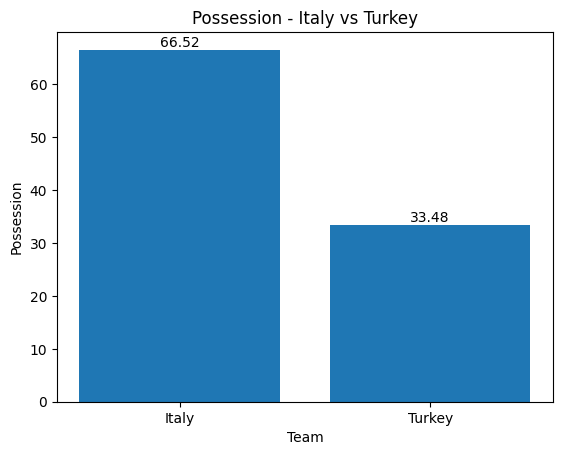

In [78]:
tvi_id = 3788741
plot_bar(possession_per_match, tvi_id, 'possession_percentage', 'Possession')

The Turks were dominated on the ball, keeping only around 33.5% of the ball during the whole match.

<h5> <b> xG Chart & Shots


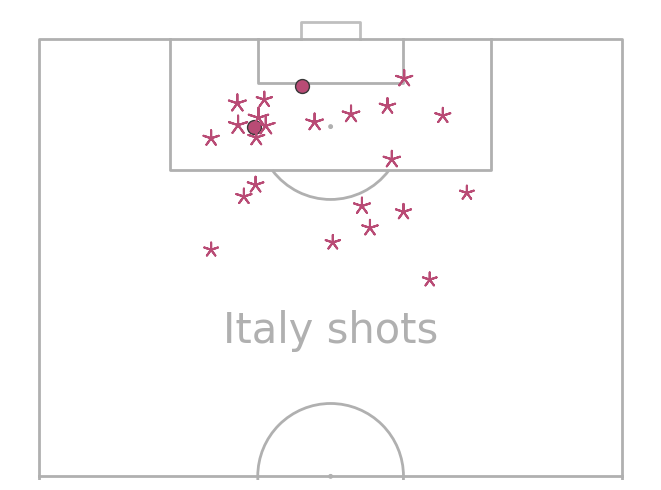

In [200]:
shotmap(tvi_id, forxg, 'Italy')

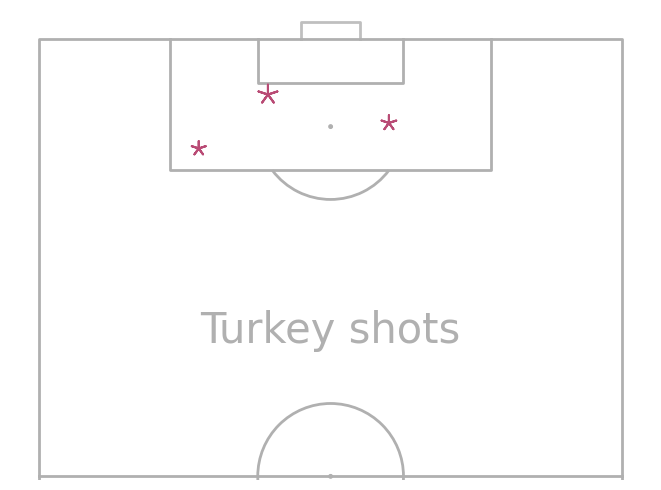

In [201]:
shotmap(tvi_id, forxg, 'Turkey')

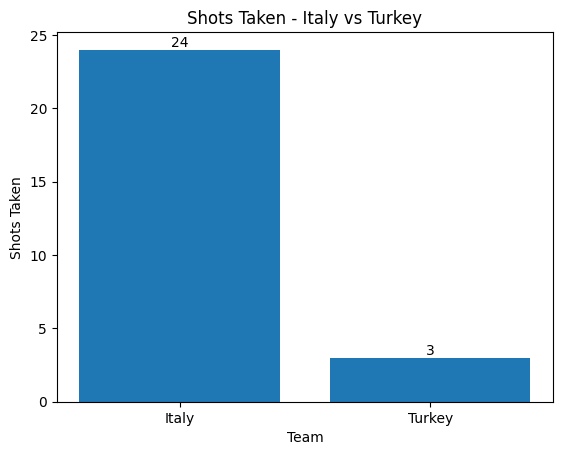

In [140]:
plot_bar(shot_count_by_match, tvi_id, 'shot_count', "Shots Taken")

C:\Users\Aykut\AppData\Local\Temp\ipykernel_4272\131464248.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match.sort_values(by='minute', inplace=True)


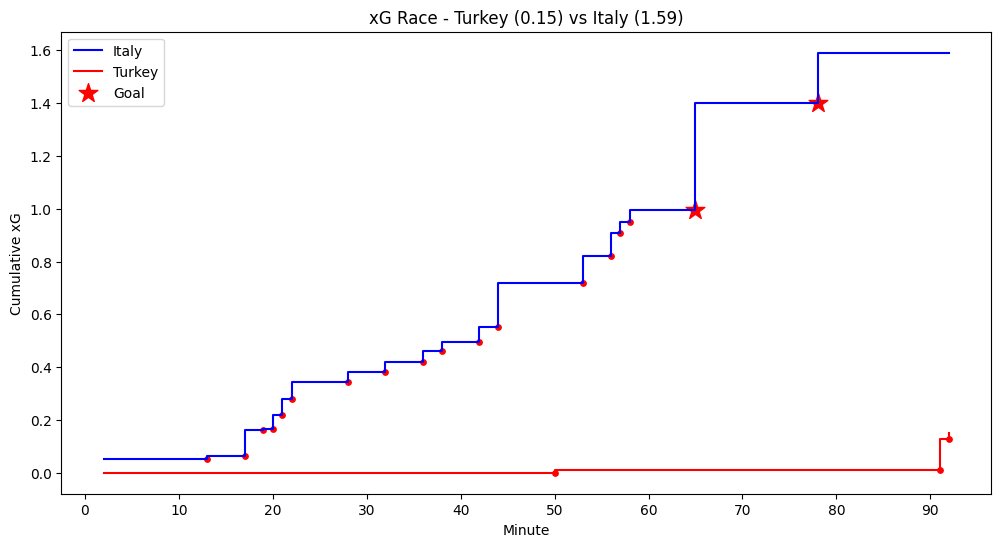

In [80]:
plot_xg_race(forxg, tvi_id, 'Turkey', 'Italy')

As seen on the xG race chart, Turkiye conceded 3 goals (with 1 own goal, 24 shots) on around 1.6 xG while producing only around 0.15 xG (3 shots). Turkiye were able to produce their only semi-noteworthy xG in injury time of the second half.

<h5> <b> Dispossession


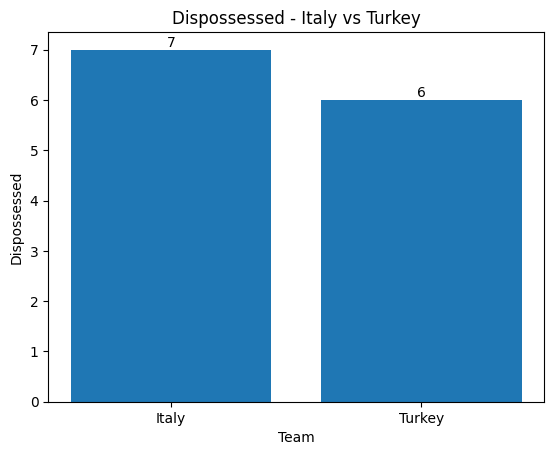

In [81]:
plot_bar(disp_count_by_match, tvi_id, 'type_name', "Dispossessed")

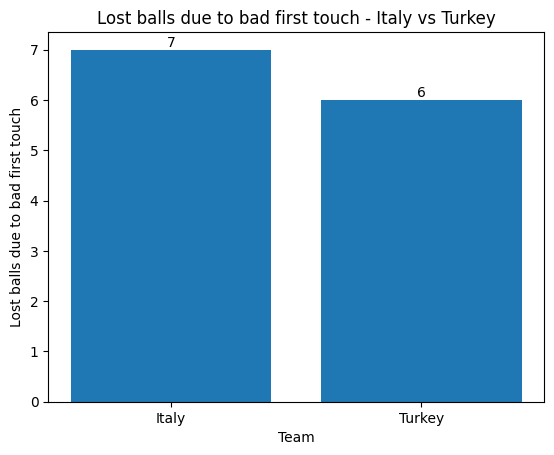

In [82]:
plot_bar(miscontrol_count_by_match, tvi_id, 'type_name', "Lost balls due to bad first touch")

Contrary to my predictions from before, Turkiye was not dispossessed much more than Italy. In fact, the Italians would start their winning campaign by losing the ball more than their opponents.

<h5> <b> Pressures made


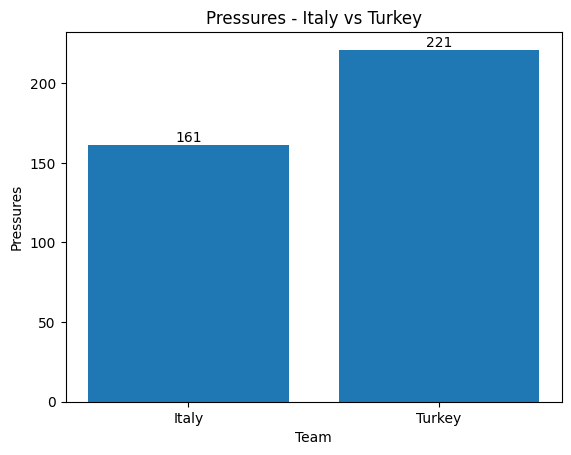

In [83]:
plot_bar(press_count_by_match, tvi_id, 'type_name', "Pressures")

Interestingly, the Turkish team pressed the Italians almost 40% more, proving my point on "lack of pressures" wrong. We should also look at counterpress', where a team presses back within 5 seconds of an open play turnover.

<h5> <b> Counterpresses


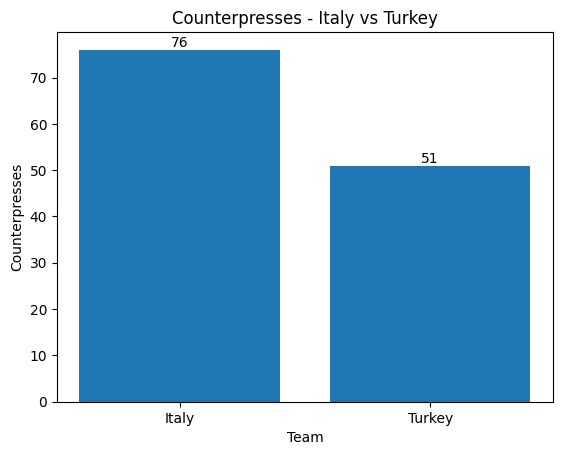

In [84]:
plot_bar(counterpress_count_by_match, tvi_id, 'counterpress', "Counterpresses")

As seen here, the Turkish national team were out-counterpressed. This means that the Turks only pressed back 51 times to get a ball they lost, while the Italians pressed 76 times. The lack of heart from the Turkish team seems to have been their demise here. Let's check out the interceptions.

<h5> <b> Interceptions


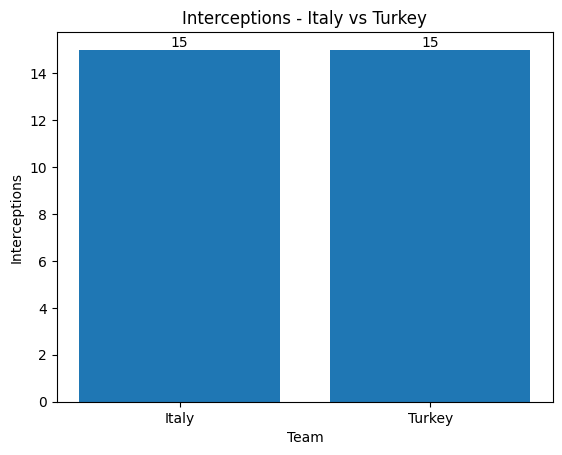

In [166]:
plot_bar(interception_count_by_match, tvi_id, 'type_name', "Interceptions")

Interceptions seem to be equal. Maybe the Turks had trouble gaining the ball and pressing in the *right* places of the pitch. Let's take a look at the zones of possession gain for both teams.

<h5> <b> Zones of Ball Loss


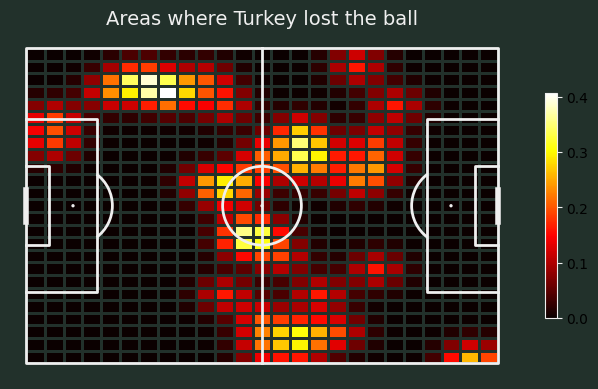

In [161]:
heatmap_gaussian(tvi_id, ball_loss, 'Turkey', 'lost the ball')

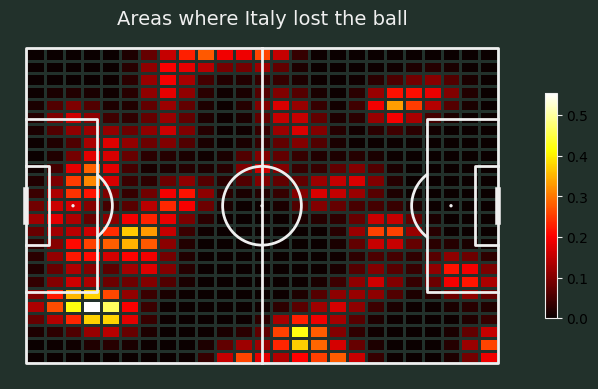

In [160]:
heatmap_gaussian(tvi_id, ball_loss, 'Italy', 'lost the ball')

I realised that area of ball loss may be distorted as attacking direction changes after half time, but after some research, I've learned that football data is orientated so the attack direction is from left to right. I'm not 100% confident of this fact, but I will take it for now.

As seen on the heatmaps, while the Italians have generally lost the ball all around the pitch, the Turks have mainly lost it in the middle of the pitch and around the left back position. (Umut Meras was the left back for Turkiye.)

The areas of loss indicate that the Italian midfield overrun the Turkish midfield and was able to go on to attack straight away. 

Let's see if the zones of pressing and counterpressing correlate with the possession loss heatmap.

<h5> <b> Zones of Press & Counterpress

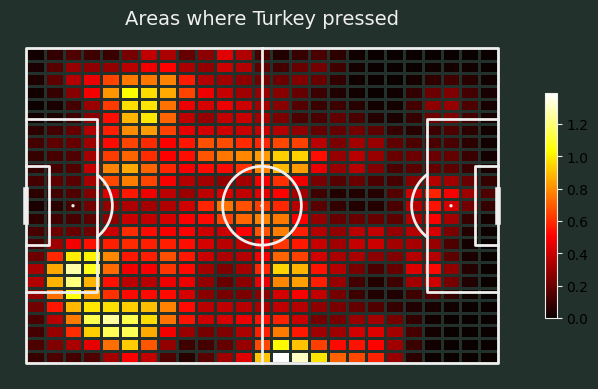

In [162]:
heatmap_gaussian(tvi_id, forpress, 'Turkey', 'pressed')

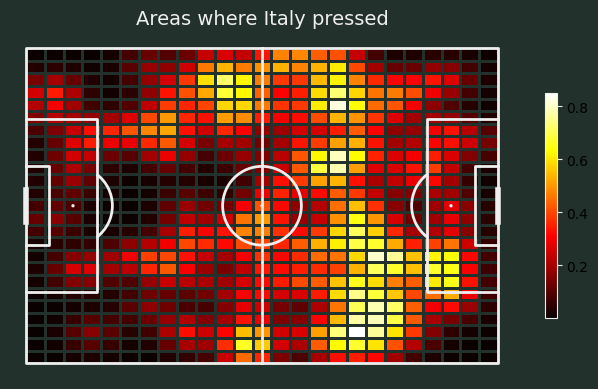

In [163]:
heatmap_gaussian(tvi_id, forpress, 'Italy', 'pressed')

A very interesting graph is upon us. Turkiye seem to have pressed mostly in their own half while Italy have pressed mostly between the Turkish defence and midfield lines. This implies that Turkey were under high pressure starting from the goalkeeper, while they could only press back to get the ball from an attacking Italy side.

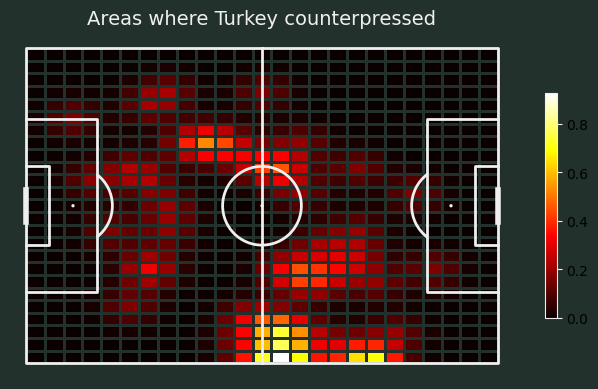

In [164]:
heatmap_gaussian(tvi_id, forcntrprs, 'Turkey', 'counterpressed')

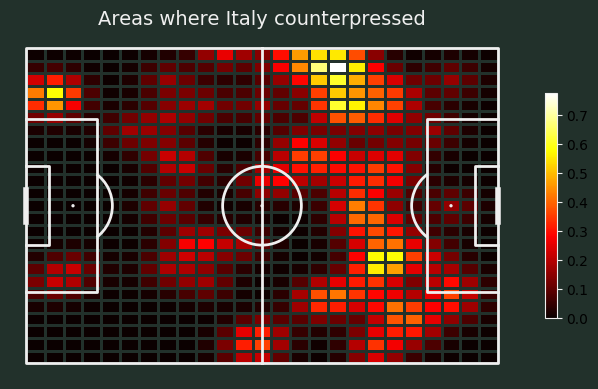

In [165]:
heatmap_gaussian(tvi_id, forcntrprs, 'Italy', 'counterpressed')

From these heatmaps, we see that Turkiye mostly counterpressed (pressing actions inside the 5 seconds after losing a ball) on the right midfield while Italy seem to have counterpressed mostly after losing the ball where Turkiye mostly PRESSED. (As seen in the pressing heatmap from before)

After looking at these heatmaps we clearly see that the Turkish side wasn't on the attacking front and "parked the bus" in front of goal.